In [1]:
!git clone https://github.com/uber-research/TuRBO
!pip install gpytorch

Cloning into 'TuRBO'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 25 (delta 4), reused 2 (delta 2), pack-reused 12
Receiving objects: 100% (25/25), 70.05 KiB | 14.01 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [5]:
from TuRBO.turbo import Turbo1
import numpy as np
import torch
import math
import matplotlib
import matplotlib.pyplot as plt

In [6]:
class Levy:
    def __init__(self, dim=10):
        self.dim = dim
        self.lb = -5 * np.ones(dim)
        self.ub = 10 * np.ones(dim)

    def __call__(self, x):
        assert len(x) == self.dim
        assert x.ndim == 1
        assert np.all(x <= self.ub) and np.all(x >= self.lb)
        w = 1 + (x - 1.0) / 4.0
        val = np.sin(np.pi * w[0]) ** 2 + \
            np.sum((w[1:self.dim - 1] - 1) ** 2 * (1 + 10 * np.sin(np.pi * w[1:self.dim - 1] + 1) ** 2)) + \
            (w[self.dim - 1] - 1) ** 2 * (1 + np.sin(2 * np.pi * w[self.dim - 1])**2)
        return val

f = Levy(10)

In [7]:
turbo1 = Turbo1(
    f=f,  # Handle to objective function
    lb=f.lb,  # Numpy array specifying lower bounds
    ub=f.ub,  # Numpy array specifying upper bounds
    n_init=20,  # Number of initial bounds from an Latin hypercube design
    max_evals = 1000,  # Maximum number of evaluations
    batch_size=10,  # How large batch size TuRBO uses
    verbose=True,  # Print information from each batch
    use_ard=True,  # Set to true if you want to use ARD for the GP kernel
    max_cholesky_size=2000,  # When we switch from Cholesky to Lanczos
    n_training_steps=50,  # Number of steps of ADAM to learn the hypers
    min_cuda=1024,  # Run on the CPU for small datasets
    device="cpu",  # "cpu" or "cuda"
    dtype="float64",  # float64 or float32
)



Using dtype = torch.float64 
Using device = cpu


In [8]:
turbo1.optimize()

Starting from fbest = 25.36
30) New best: 17.37
40) New best: 11.31
50) New best: 9.909
70) New best: 9.047
80) New best: 8.912
90) New best: 3.876
120) New best: 0.5603
170) New best: 0.4614
180) New best: 0.4474
190) New best: 0.4078
210) New best: 0.4047
220) New best: 0.3983
230) New best: 0.3959
240) New best: 0.3483
250) New best: 0.3102
270) New best: 0.2316
290) New best: 0.2172
300) New best: 0.2042
310) New best: 0.1995
320) New best: 0.1696
340) New best: 0.1546
350) New best: 0.1478
360) New best: 0.1356
380) Restarting with fbest = 0.1356
Starting from fbest = 18.63
770) Restarting with fbest = 0.5646
Starting from fbest = 22.19


In [9]:
X = turbo1.X  # Evaluated points
fX = turbo1.fX  # Observed values
ind_best = np.argmin(fX)
f_best, x_best = fX[ind_best], X[ind_best, :]

print("Best value found:\n\tf(x) = %.3f\nObserved at:\n\tx = %s" % (f_best, np.around(x_best, 3)))

Best value found:
	f(x) = 0.136
Observed at:
	x = [4.955 1.048 1.009 0.927 1.049 0.602 0.972 0.416 0.963 0.903]


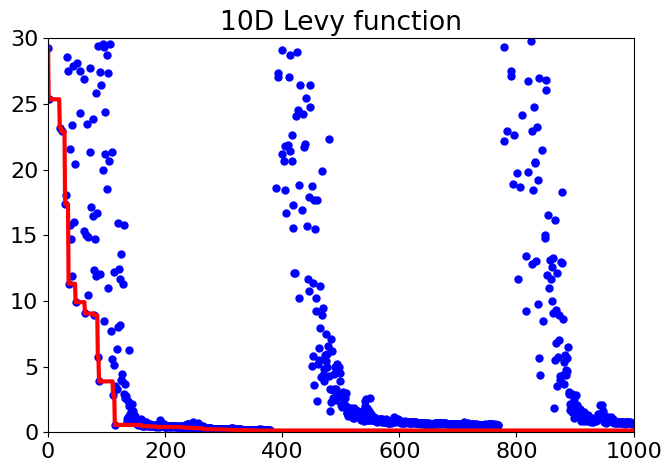

In [10]:
fig = plt.figure(figsize=(7, 5))
matplotlib.rcParams.update({'font.size': 16})
plt.plot(fX, 'b.', ms=10)  # Plot all evaluated points as blue dots
plt.plot(np.minimum.accumulate(fX), 'r', lw=3)  # Plot cumulative minimum as a red line
plt.xlim([0, len(fX)])
plt.ylim([0, 30])
plt.title("10D Levy function")

plt.tight_layout()
plt.show()